In [92]:
if '__IPYTHON__' in globals():
    from IPython import get_ipython
    ipython = get_ipython()
    ipython.magic('load_ext autoreload')
    ipython.magic('autoreload 2')

import tempfile
import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay,ConfusionMatrixDisplay, PrecisionRecallDisplay

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_validate, train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import FunctionTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from sklearn import set_config
set_config(display="diagram")

### 1. Import data

In [93]:
target = "Survived"
random_state = 5646
test_size = 0.3
n_estimators = 200
min_samples_split = 20


In [94]:
df = pd.read_csv("../data/raw/train.csv")
X, y = (
    df.drop(target, axis=1),
    df.pop(target),
)

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, test_size=test_size, stratify=y)

### 2. Prepare data

In [96]:
def identify_deck(X, fill_missing="UNK"):
    # Create Deck column
    X = X.apply(lambda s: s[0] if s.str.contains("^[A-Za-z]").any() else fill_missing, axis=1)
    return np.array(X).reshape(-1, 1)

def fill_by_group(X, group_by, fill_by="median"):    
    X["Age"] = X["Age"].fillna(X.groupby(group_by)["Age"].transform(fill_by))
    return np.array(X["Age"]).reshape(-1, 1)

def count_features(X, offset=0):
    X = X.apply(lambda x: x.sum(), axis=1) + offset
    return np.array(X).reshape(-1, 1)


def discretize_feature(X, bins=[0,1], labels=None):
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)
    X = X.apply(lambda x: pd.cut(x, bins=bins, include_lowest=True,labels=labels))
    return np.array(X).reshape(-1, 1)

def boolean_feature(X):
    X = X.apply(lambda x: x.sum() == 0, axis=1).astype(int)
    return np.array(X).reshape(-1, 1)

def extract_titles(X):
    X = X.apply(lambda x: x.str.extract(" ([A-Za-z]+)\.", expand=False))
    return np.array(X).reshape(-1, 1)


### 3. Create the pipeline

In [97]:
# Perform imputation
data_pipeline = make_column_transformer(
    # Create the familysize feature
    (FunctionTransformer(count_features, kw_args={"offset": 1}), ["SibSp", "Parch"]),
    # Create is_alone feature
    (FunctionTransformer(boolean_feature), ["SibSp", "Parch"]),
    # Create the title feature
    (
        make_pipeline(
            FunctionTransformer(extract_titles),
            OneHotEncoder(handle_unknown="ignore", sparse=False),
        ),
        ["Name"],
    ),
    # Create the deck feature
    (
        make_pipeline(
            FunctionTransformer(identify_deck), OneHotEncoder(handle_unknown="ignore", sparse=False)
        ),
        ["Cabin"],
    ),

    # Create the fare_band feature
    (
        make_pipeline(
            SimpleImputer(strategy="median"),
            FunctionTransformer(
                discretize_feature,
                kw_args=dict(
                    bins=[0, 8, 15, 32, 100, 600],
                    labels=["Very Low", "Low", "Medium", "High", "Very High"],
                ),
            ),
            OrdinalEncoder(
                categories=[["Very Low", "Low", "Medium", "High", "Very High"]]
            ),
        ),
        ["Fare"],
    ),
    # Create the age_band feature
    (
        make_pipeline(
            FunctionTransformer(
                fill_by_group, kw_args=dict(group_by="Pclass", fill_by="median")
            ),
            FunctionTransformer(
                discretize_feature,
                kw_args=dict(
                    bins=[0, 14, 24, 64, 150],
                    labels=["Children", "Youth", "Adults", "Seniors"],
                ),
            ),
            OrdinalEncoder(categories=[["Children", "Youth", "Adults", "Seniors"]]),
        ),
        ["Age", "Pclass"],
    ), 
    (
        make_pipeline(
            SimpleImputer(strategy="most_frequent"),
            OneHotEncoder(handle_unknown="ignore", sparse=False),
        ),
        ["Embarked", "Sex", "Pclass"],
    ),
    ("passthrough", ["SibSp", "Parch"])
)


### 4. Create the model

In [98]:
model = RandomForestClassifier(
    n_estimators=n_estimators,
    random_state=random_state,
    min_samples_split=min_samples_split,
)

### 5. Validation

In [99]:
# Transform data
X_train_features = data_pipeline.fit_transform(X_train)
X_test_features = data_pipeline.transform(X_test)

# Metrics to evaluate the model
scoring = ("accuracy", "average_precision", "neg_brier_score", "roc_auc", "f1")

# Cross validation
scores = cross_validate(
    model, X_train_features, y_train, cv=5, scoring=scoring, n_jobs=-1
)

# Mean value of the metrics
for k, v in scores.items():
    #print(f"{k}: {v.mean():0.4f} (std {v.std():0.4f})")
    print ("{:<25} {:<8.4f} {:<4.4f}".format( k, v.mean(), v.std()))


fit_time                  0.1889   0.0114
score_time                0.0260   0.0002
test_accuracy             0.8121   0.0462
test_average_precision    0.8329   0.0607
test_neg_brier_score      -0.1364  0.0230
test_roc_auc              0.8616   0.0427
test_f1                   0.7362   0.0669


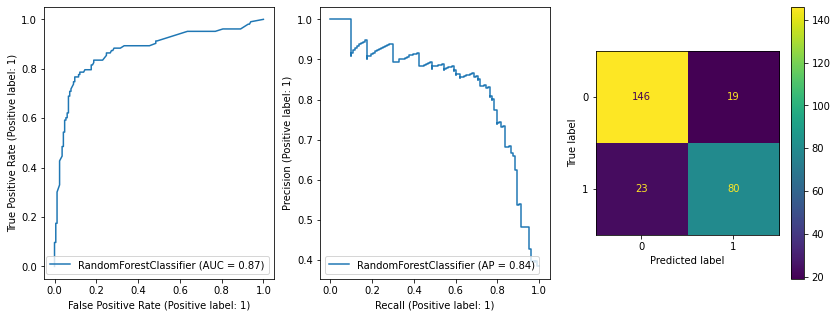

In [100]:
model.fit(X_train_features, y_train)
fig, ax = plt.subplots(1, 3, figsize=(14, 5))
RocCurveDisplay.from_estimator(model, X_test_features, y_test, ax=ax[0])
PrecisionRecallDisplay.from_estimator(model, X_test_features, y_test, ax=ax[1])
ConfusionMatrixDisplay.from_estimator(model, X_test_features, y_test, ax=ax[2])
plt.show()

In [101]:
test = pd.read_csv("../data/raw/test.csv")
test_features = data_pipeline.transform(test)

In [102]:
model.fit(X_train_features, y_train)
y_test_pred = model.predict(test_features)

submission = pd.read_csv("../data/gender_submission.csv")
submission[target]= y_test_pred
submission[target] = submission[target]

with tempfile.TemporaryDirectory() as temp_dir:
    tmp_file_path  = f"{temp_dir}/{model.__class__.__name__}.csv"
    ! kaggle competitions submit titanic -f RandomForestClassifier.csv -m "Random Forest Classifier"

100%|████████████████████████████████████████| 2.77k/2.77k [00:02<00:00, 985B/s]
Successfully submitted to Titanic - Machine Learning from Disaster